In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import os

DATA_DIR = '/content/drive/My Drive/Example codes/Images'
print(os.listdir(DATA_DIR))

['00001']


In [ ]:
print(os.listdir(DATA_DIR+'/00001')[:10])

['img00000000.png', 'img00000003.png', 'img00000001.png', 'img00000002.png', 'img00000007.png', 'img00000011.png', 'img00000017.png', 'img00000014.png', 'img00000012.png', 'img00000013.png']


In [ ]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [ ]:
image_size = 64
batch_size = 128
stats = (0.5,0.5, 0.5), (0.5,0.5, 0.5)

In [ ]:
train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)

In [ ]:
img = 0
for images, _ in train_ds:
        print(images.shape)
        img = images
        ##show_images(images, nmax)
        break

torch.Size([3, 64, 64])


In [ ]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [ ]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        print(images.shape)
        show_images(images, nmax)
        break

torch.Size([128, 3, 64, 64])


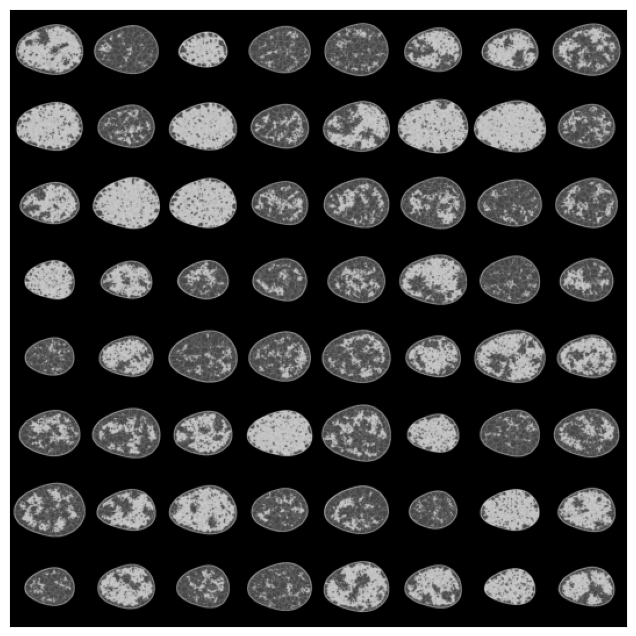

In [ ]:
show_batch(train_dl)

##Connecting to GPU

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)

In [ ]:
import torch.nn as nn

In [ ]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [ ]:
discriminator = to_device(discriminator, device)

In [ ]:
latent_size = 128

In [ ]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

torch.Size([128, 3, 64, 64])


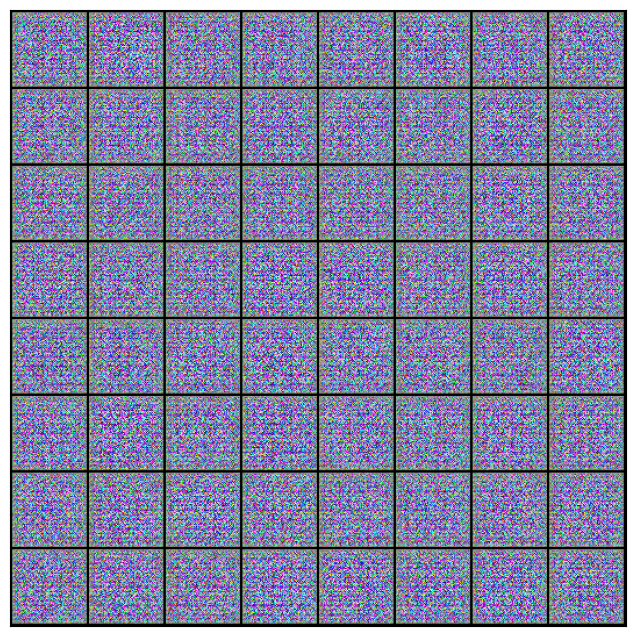

In [ ]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [ ]:
generator = to_device(generator, device)

In [ ]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [ ]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [ ]:
from torchvision.utils import save_image

In [ ]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [ ]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [ ]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Saving generated-images-0000.png


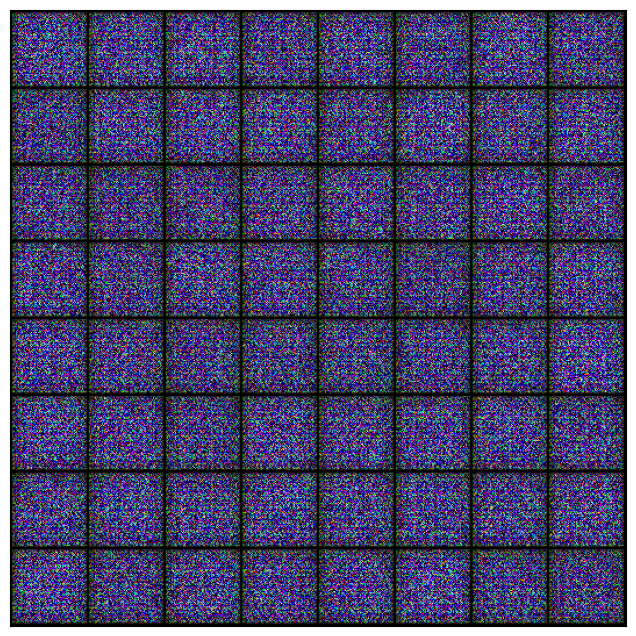

In [ ]:
save_samples(0, fixed_latent)

In [ ]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [ ]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [ ]:
lr = 0.002
epochs = 100

In [ ]:
history = fit(epochs, lr)

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [1/100], loss_g: 5.2810, loss_d: 0.4294, real_score: 0.8746, fake_score: 0.2287
Saving generated-images-0001.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [2/100], loss_g: 3.4486, loss_d: 0.2333, real_score: 0.8477, fake_score: 0.0259
Saving generated-images-0002.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [3/100], loss_g: 0.5398, loss_d: 1.7536, real_score: 0.2804, fake_score: 0.0595
Saving generated-images-0003.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [4/100], loss_g: 3.8025, loss_d: 0.2839, real_score: 0.9593, fake_score: 0.1845
Saving generated-images-0004.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [5/100], loss_g: 9.4773, loss_d: 0.8806, real_score: 0.5866, fake_score: 0.0002
Saving generated-images-0005.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [6/100], loss_g: 8.3135, loss_d: 0.0429, real_score: 0.9832, fake_score: 0.0194
Saving generated-images-0006.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [7/100], loss_g: 9.9512, loss_d: 0.2844, real_score: 0.8149, fake_score: 0.0007
Saving generated-images-0007.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [8/100], loss_g: 12.7185, loss_d: 18.3165, real_score: 0.0000, fake_score: 0.0000
Saving generated-images-0008.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [9/100], loss_g: 4.1799, loss_d: 0.0700, real_score: 0.9697, fake_score: 0.0305
Saving generated-images-0009.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [10/100], loss_g: 7.3408, loss_d: 0.3344, real_score: 0.7495, fake_score: 0.0006
Saving generated-images-0010.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [11/100], loss_g: 1.2945, loss_d: 7.3520, real_score: 0.0010, fake_score: 0.0002
Saving generated-images-0011.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [12/100], loss_g: 4.6136, loss_d: 0.1953, real_score: 0.9059, fake_score: 0.0833
Saving generated-images-0012.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [13/100], loss_g: 6.0037, loss_d: 0.3558, real_score: 0.9959, fake_score: 0.2732
Saving generated-images-0013.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [14/100], loss_g: 4.5017, loss_d: 0.1190, real_score: 0.9893, fake_score: 0.0984
Saving generated-images-0014.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [15/100], loss_g: 13.1118, loss_d: 0.5420, real_score: 0.9689, fake_score: 0.3779
Saving generated-images-0015.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [16/100], loss_g: 1.3179, loss_d: 0.8359, real_score: 0.6853, fake_score: 0.2656
Saving generated-images-0016.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [17/100], loss_g: 0.5369, loss_d: 2.3036, real_score: 0.1697, fake_score: 0.0443
Saving generated-images-0017.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [18/100], loss_g: 1.9636, loss_d: 0.7938, real_score: 0.8504, fake_score: 0.4555
Saving generated-images-0018.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [19/100], loss_g: 1.3822, loss_d: 3.4440, real_score: 0.0640, fake_score: 0.0060
Saving generated-images-0019.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [20/100], loss_g: 0.5693, loss_d: 1.0768, real_score: 0.4452, fake_score: 0.1047
Saving generated-images-0020.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [21/100], loss_g: 1.5206, loss_d: 0.5044, real_score: 0.6848, fake_score: 0.1026
Saving generated-images-0021.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [22/100], loss_g: 0.3785, loss_d: 2.2059, real_score: 0.1911, fake_score: 0.0798
Saving generated-images-0022.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [23/100], loss_g: 0.7476, loss_d: 1.3409, real_score: 0.3311, fake_score: 0.1550
Saving generated-images-0023.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [24/100], loss_g: 1.5087, loss_d: 0.7581, real_score: 0.6040, fake_score: 0.1597
Saving generated-images-0024.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [25/100], loss_g: 3.4118, loss_d: 0.7126, real_score: 0.8184, fake_score: 0.3591
Saving generated-images-0025.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [26/100], loss_g: 0.7626, loss_d: 1.5323, real_score: 0.2627, fake_score: 0.0604
Saving generated-images-0026.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [27/100], loss_g: 1.1984, loss_d: 1.3029, real_score: 0.3346, fake_score: 0.0549
Saving generated-images-0027.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [28/100], loss_g: 1.2210, loss_d: 1.1195, real_score: 0.4332, fake_score: 0.1603
Saving generated-images-0028.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [29/100], loss_g: 3.3140, loss_d: 0.6509, real_score: 0.8428, fake_score: 0.3566
Saving generated-images-0029.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [30/100], loss_g: 3.2544, loss_d: 0.7482, real_score: 0.9121, fake_score: 0.4278
Saving generated-images-0030.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [31/100], loss_g: 1.6801, loss_d: 1.0237, real_score: 0.5943, fake_score: 0.2495
Saving generated-images-0031.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [32/100], loss_g: 1.5234, loss_d: 0.7417, real_score: 0.9067, fake_score: 0.4558
Saving generated-images-0032.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [33/100], loss_g: 3.0442, loss_d: 0.7347, real_score: 0.7641, fake_score: 0.3526
Saving generated-images-0033.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [34/100], loss_g: 2.7123, loss_d: 0.6742, real_score: 0.7638, fake_score: 0.2921
Saving generated-images-0034.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [35/100], loss_g: 2.5740, loss_d: 0.4829, real_score: 0.7080, fake_score: 0.1058
Saving generated-images-0035.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [36/100], loss_g: 3.3226, loss_d: 0.6982, real_score: 0.8116, fake_score: 0.3669
Saving generated-images-0036.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [37/100], loss_g: 4.0481, loss_d: 1.3642, real_score: 0.7655, fake_score: 0.5886
Saving generated-images-0037.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [38/100], loss_g: 1.6550, loss_d: 1.3541, real_score: 0.5421, fake_score: 0.4725
Saving generated-images-0038.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [39/100], loss_g: 0.8230, loss_d: 1.0439, real_score: 0.4928, fake_score: 0.1974
Saving generated-images-0039.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [40/100], loss_g: 4.1509, loss_d: 0.8023, real_score: 0.7709, fake_score: 0.3706
Saving generated-images-0040.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [41/100], loss_g: 2.8925, loss_d: 0.9846, real_score: 0.7420, fake_score: 0.4804
Saving generated-images-0041.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [42/100], loss_g: 2.2756, loss_d: 0.5013, real_score: 0.8128, fake_score: 0.2414
Saving generated-images-0042.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [43/100], loss_g: 1.0958, loss_d: 1.1465, real_score: 0.4152, fake_score: 0.1701
Saving generated-images-0043.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [44/100], loss_g: 2.9745, loss_d: 1.4255, real_score: 0.8996, fake_score: 0.7124
Saving generated-images-0044.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [45/100], loss_g: 1.0322, loss_d: 1.2135, real_score: 0.4024, fake_score: 0.1905
Saving generated-images-0045.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [46/100], loss_g: 1.2134, loss_d: 1.7406, real_score: 0.2202, fake_score: 0.0660
Saving generated-images-0046.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [47/100], loss_g: 0.1874, loss_d: 1.9987, real_score: 0.1646, fake_score: 0.0835
Saving generated-images-0047.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [48/100], loss_g: 5.7011, loss_d: 2.0413, real_score: 0.9258, fake_score: 0.8327
Saving generated-images-0048.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [49/100], loss_g: 1.3224, loss_d: 1.0931, real_score: 0.4680, fake_score: 0.2218
Saving generated-images-0049.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [50/100], loss_g: 4.9584, loss_d: 1.2614, real_score: 0.8181, fake_score: 0.6289
Saving generated-images-0050.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [51/100], loss_g: 4.0926, loss_d: 2.1170, real_score: 0.9335, fake_score: 0.8462
Saving generated-images-0051.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [52/100], loss_g: 1.5637, loss_d: 2.1868, real_score: 0.1615, fake_score: 0.0310
Saving generated-images-0052.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [53/100], loss_g: 2.8286, loss_d: 1.0000, real_score: 0.6937, fake_score: 0.4167
Saving generated-images-0053.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [54/100], loss_g: 2.2650, loss_d: 1.0672, real_score: 0.6424, fake_score: 0.4074
Saving generated-images-0054.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [55/100], loss_g: 1.2138, loss_d: 1.3654, real_score: 0.3064, fake_score: 0.1109
Saving generated-images-0055.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [56/100], loss_g: 1.2961, loss_d: 0.8283, real_score: 0.7811, fake_score: 0.4214
Saving generated-images-0056.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [57/100], loss_g: 1.1371, loss_d: 1.4940, real_score: 0.2842, fake_score: 0.0914
Saving generated-images-0057.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [58/100], loss_g: 2.6974, loss_d: 1.3072, real_score: 0.8985, fake_score: 0.6842
Saving generated-images-0058.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [59/100], loss_g: 2.4877, loss_d: 1.5225, real_score: 0.8409, fake_score: 0.6904
Saving generated-images-0059.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [60/100], loss_g: 1.9429, loss_d: 1.5479, real_score: 0.3331, fake_score: 0.0643
Saving generated-images-0060.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [61/100], loss_g: 1.3636, loss_d: 1.0261, real_score: 0.5239, fake_score: 0.2613
Saving generated-images-0061.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [62/100], loss_g: 2.6375, loss_d: 0.7933, real_score: 0.7559, fake_score: 0.3751
Saving generated-images-0062.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [63/100], loss_g: 1.5879, loss_d: 0.8925, real_score: 0.6399, fake_score: 0.3068
Saving generated-images-0063.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [64/100], loss_g: 3.6702, loss_d: 1.3943, real_score: 0.8291, fake_score: 0.6773
Saving generated-images-0064.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [65/100], loss_g: 3.4257, loss_d: 1.1264, real_score: 0.8605, fake_score: 0.5962
Saving generated-images-0065.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [66/100], loss_g: 2.4908, loss_d: 0.9443, real_score: 0.7506, fake_score: 0.4563
Saving generated-images-0066.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [67/100], loss_g: 1.5781, loss_d: 0.8394, real_score: 0.6168, fake_score: 0.2758
Saving generated-images-0067.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [68/100], loss_g: 3.1628, loss_d: 1.2791, real_score: 0.7876, fake_score: 0.5703
Saving generated-images-0068.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [69/100], loss_g: 1.7664, loss_d: 0.9985, real_score: 0.5879, fake_score: 0.3264
Saving generated-images-0069.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [70/100], loss_g: 2.7903, loss_d: 1.2729, real_score: 0.6977, fake_score: 0.5628
Saving generated-images-0070.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [71/100], loss_g: 1.8680, loss_d: 0.8376, real_score: 0.6480, fake_score: 0.2910
Saving generated-images-0071.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [72/100], loss_g: 1.2343, loss_d: 1.1158, real_score: 0.7443, fake_score: 0.5008
Saving generated-images-0072.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [73/100], loss_g: 1.5785, loss_d: 1.0124, real_score: 0.5991, fake_score: 0.3525
Saving generated-images-0073.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [74/100], loss_g: 2.0246, loss_d: 0.8915, real_score: 0.6605, fake_score: 0.3415
Saving generated-images-0074.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [75/100], loss_g: 1.7401, loss_d: 1.2393, real_score: 0.5572, fake_score: 0.4321
Saving generated-images-0075.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [76/100], loss_g: 3.1021, loss_d: 1.0556, real_score: 0.8584, fake_score: 0.5813
Saving generated-images-0076.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [77/100], loss_g: 3.0370, loss_d: 1.2954, real_score: 0.8065, fake_score: 0.6027
Saving generated-images-0077.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [78/100], loss_g: 4.1652, loss_d: 1.2795, real_score: 0.7329, fake_score: 0.5781
Saving generated-images-0078.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [79/100], loss_g: 1.8280, loss_d: 1.3011, real_score: 0.5307, fake_score: 0.4222
Saving generated-images-0079.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [80/100], loss_g: 1.4504, loss_d: 2.5172, real_score: 0.1311, fake_score: 0.0313
Saving generated-images-0080.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [81/100], loss_g: 2.2957, loss_d: 1.4039, real_score: 0.8359, fake_score: 0.6292
Saving generated-images-0081.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [82/100], loss_g: 2.2323, loss_d: 1.5498, real_score: 0.8111, fake_score: 0.7170
Saving generated-images-0082.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [83/100], loss_g: 2.6792, loss_d: 1.4079, real_score: 0.8827, fake_score: 0.6992
Saving generated-images-0083.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [84/100], loss_g: 0.8835, loss_d: 1.7084, real_score: 0.2397, fake_score: 0.1345
Saving generated-images-0084.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [85/100], loss_g: 1.9257, loss_d: 1.2418, real_score: 0.7099, fake_score: 0.5663
Saving generated-images-0085.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [86/100], loss_g: 2.1273, loss_d: 1.1976, real_score: 0.7271, fake_score: 0.5309
Saving generated-images-0086.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [87/100], loss_g: 1.1032, loss_d: 1.0574, real_score: 0.5228, fake_score: 0.3041
Saving generated-images-0087.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [88/100], loss_g: 2.1288, loss_d: 1.5150, real_score: 0.6483, fake_score: 0.6412
Saving generated-images-0088.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [89/100], loss_g: 1.6958, loss_d: 1.2919, real_score: 0.6902, fake_score: 0.5795
Saving generated-images-0089.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [90/100], loss_g: 2.5512, loss_d: 1.4850, real_score: 0.7481, fake_score: 0.6795
Saving generated-images-0090.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [91/100], loss_g: 1.2012, loss_d: 1.3756, real_score: 0.4975, fake_score: 0.4201
Saving generated-images-0091.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [92/100], loss_g: 0.8541, loss_d: 1.2723, real_score: 0.4583, fake_score: 0.3316
Saving generated-images-0092.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [93/100], loss_g: 0.7130, loss_d: 1.5533, real_score: 0.2810, fake_score: 0.1880
Saving generated-images-0093.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [94/100], loss_g: 1.4703, loss_d: 1.3231, real_score: 0.6139, fake_score: 0.5198
Saving generated-images-0094.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [95/100], loss_g: 1.8224, loss_d: 1.4565, real_score: 0.6493, fake_score: 0.6073
Saving generated-images-0095.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [96/100], loss_g: 1.3288, loss_d: 1.2658, real_score: 0.5990, fake_score: 0.5062
Saving generated-images-0096.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [97/100], loss_g: 0.6655, loss_d: 1.8697, real_score: 0.2069, fake_score: 0.1334
Saving generated-images-0097.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [98/100], loss_g: 0.8488, loss_d: 1.5296, real_score: 0.3779, fake_score: 0.3808
Saving generated-images-0098.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [99/100], loss_g: 1.0668, loss_d: 1.2466, real_score: 0.5467, fake_score: 0.4497
Saving generated-images-0099.png


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch [100/100], loss_g: 1.5896, loss_d: 1.2142, real_score: 0.5668, fake_score: 0.4495
Saving generated-images-0100.png


In [ ]:
losses_g, losses_d, real_scores, fake_scores = history

In [ ]:
# Save the model checkpoints 
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

In [ ]:
from IPython.display import Image

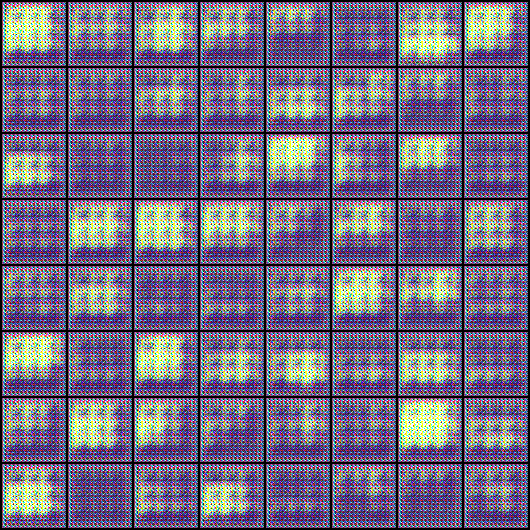

In [ ]:
Image('./generated/generated-images-0001.png')

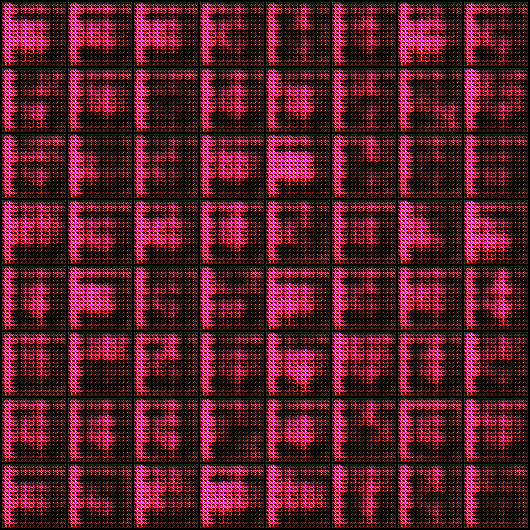

In [ ]:
Image('./generated/generated-images-0005.png')

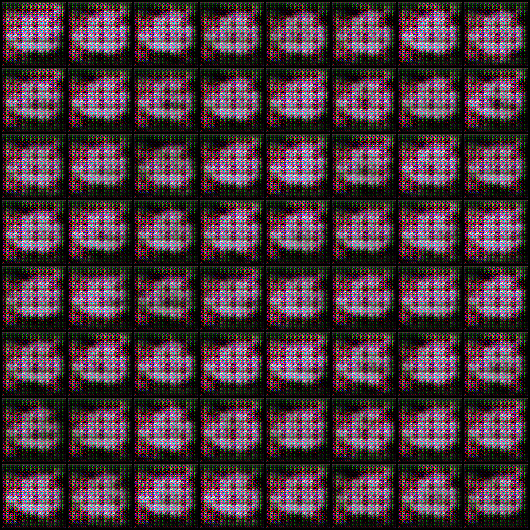

In [ ]:
Image('./generated/generated-images-0010.png')

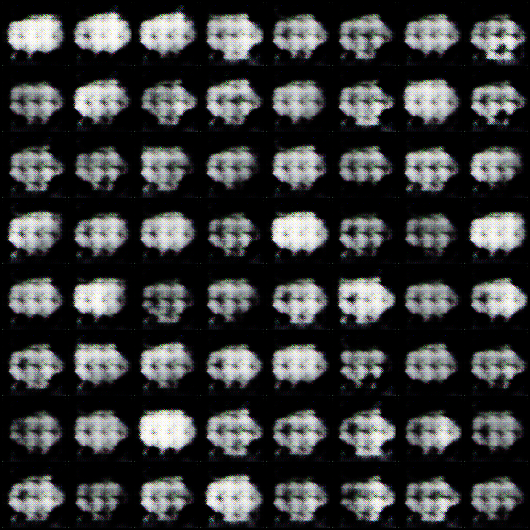

In [ ]:
Image('./generated/generated-images-0025.png')

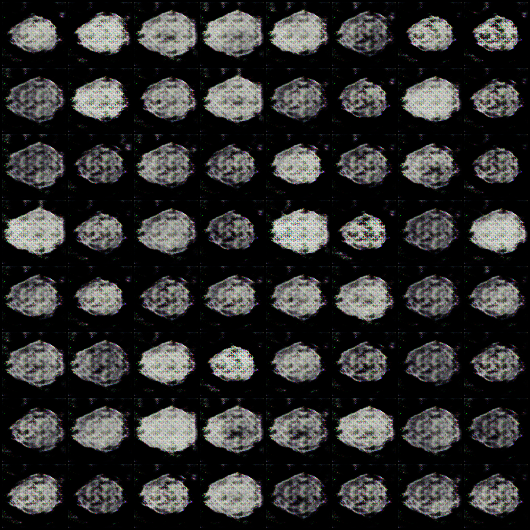

In [ ]:
Image('./generated/generated-images-0050.png')

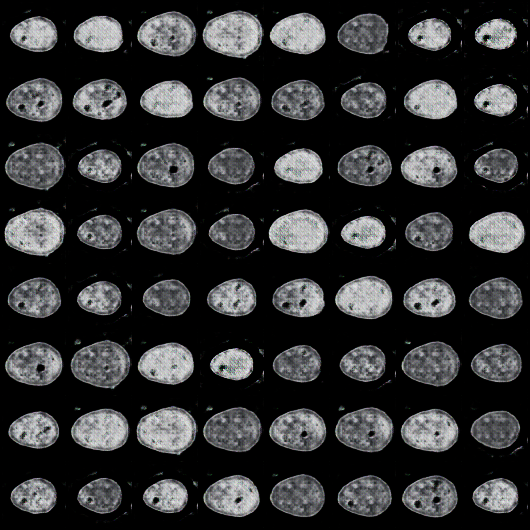

In [ ]:
Image('/content/generated/generated-images-0100.png')

In [ ]:
import cv2
import os

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

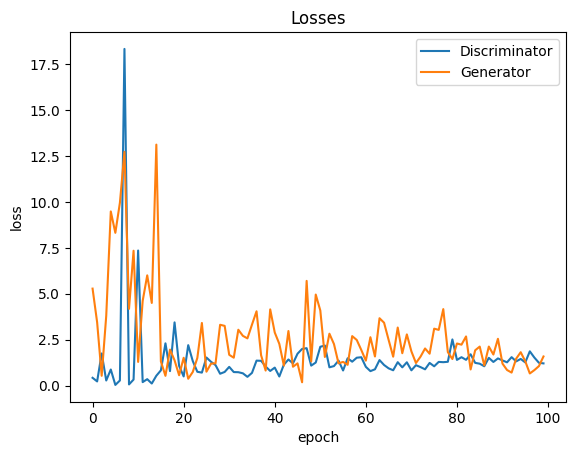

In [ ]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

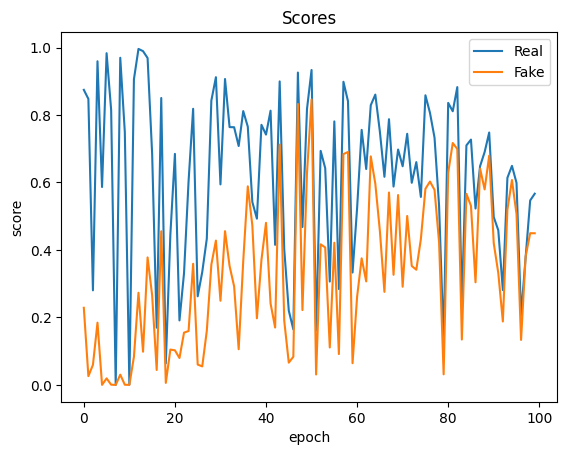

In [ ]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');